In [1]:
from keras.datasets import fashion_mnist
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from random import randrange
import itertools
import time

Using TensorFlow backend.


## Loading Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
# define k neighbor range
neighbor_range_lower=4
neighbor_range_upper=5

# Distance type, cosine distance produced the best outcome during the study
# 'default' - L2 distance
# 'manhattan' - Manhattan distance
# 'cosine' - Cosine distance

dist_type = 'l2'

In [4]:
## Data Pre-processing

In [5]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [6]:
# global centering
X_train = X_train - X_train.mean(axis=0)
X_test = X_test - X_test.mean(axis=0)


# local centering
X_train -= X_train.mean(axis=1).reshape(X_train.shape[0], -1)
X_test -= X_test.mean(axis=1).reshape(X_test.shape[0], -1)

## Computing Distances

In [7]:
def compute_distances(X_train, X_test, dist_type='l2'):
    if dist_type == 'manhattan':
        # Compute Manhattan distance
        return distance.cdist(X_train, X_test, 'cityblock').T
    elif dist_type == 'cosine':
        # Compute cosine distance
        return distance.cdist(X_train, X_test, 'cosine').T
    elif dist_type == 'l2':
        # Compute L2 distance - (x - y)**2 = X**2 + y**2 - 2xy
        # result X_test.shape[0] row  x X_train.shape[0] column matrix
        return -2 * np.dot(X_test, X_train.T) + np.sum(X_train**2, axis=1) + np.sum(X_test**2, axis=1)[:, np.newaxis]

In [8]:
def predict(X_train, y_train, X_test, k):
    dists = compute_distances(X_train, X_test, dist_type=dist_type)
    y_pred = np.zeros(X_test.shape[0])

    for i in range(X_test.shape[0]):
        nearest_neighbors = []
        labels = y_train[np.argsort(dists[i,:])].flatten()

        # find k nearest neighbors
        nearest_neighbors = labels[:k]

        # find the most common label
        max_label = nearest_neighbors[0]
        for j in set(list(nearest_neighbors)):
            num_labels = list(nearest_neighbors).count(j)
            if num_labels > list(nearest_neighbors).count(max_label):
                max_label = j
        y_pred[i] = max_label
        # y_pred[i] = most_common_neighbor(labels, k)
    return y_pred

## Prediction and predictive performace test with Cross Validation

In [9]:
def cross_validation(X_train, y_train, k_neighbors, k_fold=10):
    accuracy_list = []
    print('k-NN with {} neighbors:'.format(k_neighbors))
    if k_fold > 1:
        for i in range(k_fold):
            m = int(len(X_train) / k_fold * i)
            n = int(len(X_train) / k_fold * (i + 1))   
            k_fold_X_train = np.delete(X_train, np.s_[m:n], axis=0)
            k_fold_y_train = np.delete(y_train, np.s_[m:n], axis=0)
            k_fold_X_test = X_train[m:n]
            k_fold_y_test = y_train[m:n]
            y_pred = predict(k_fold_X_train, k_fold_y_train, k_fold_X_test, k_neighbors)
            accuracy = 100 * np.mean(y_pred == y_test.flatten()) 
            print('Test set index: {} to {}, accuracy {:.2f}%'.format(m, n, accuracy))
            accuracy_list.append(accuracy)
        return np.mean(accuracy_list)
    else:
        y_pred = predict(X_train, y_train, X_test, k_neighbors)
        accuracy = 100 * np.mean(y_pred == y_test.flatten()) 
        print('Test accuracy {:.2f}%'.format(accuracy))
        return accuracy

In [10]:
# Finding optimised k within the give range
test_accuracy = []
neighbors = np.arange(neighbor_range_lower, neighbor_range_upper)

cur_avg_accuracy = 0
cur_k = 1

for k in neighbors:
    start_time = time.time()
    avg_accuracy = cross_validation(X_train, y_train, k, k_fold=1)
    end_time = time.time()
    if avg_accuracy > cur_avg_accuracy:
        cur_k = k
        cur_avg_accuracy = avg_accuracy
    test_accuracy.append(avg_accuracy)
    print('Average training accuracy: {:.2f}% when k is {}.  Runtime: {:.2f}'.format(avg_accuracy, k, end_time-start_time))

print('Highest average accuracy is {} when k is {}'.format(cur_avg_accuracy, cur_k))

k-NN with 4 neighbors:
Test accuracy 86.19%
Average training accuracy: 86.19% when k is 4.  Runtime: 111.96
Highest average accuracy is 86.19 when k is 4


## Performance Evaluation

In [11]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.figure(figsize = (8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(len(classes))
    y_tick_marks = np.arange(-0.5, len(classes))
    plt.xticks(x_tick_marks, classes)
    plt.yticks(y_tick_marks, classes)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.0f'), ha ='center', va ='center', 
                 color='white' if cm[i, j] > thresh else 'black')
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [12]:
def compute_confusion_matrix(y_test, y_pred):
    c_matrix = np.zeros((10, 10))
    for a, p in zip(y_test, y_pred):
        c_matrix[int(a)][int(p)] += 1
    return c_matrix

In [13]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def f1_score(label, confusion_matrix):
    return 2 * precision(label, confusion_matrix)*recall(label, confusion_matrix) / \
        (precision(label, confusion_matrix) + recall(label, confusion_matrix))

def support(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return row.sum()

In [14]:
y_pred = predict(X_train, y_train, X_test, cur_k)
accuracy = 100 * np.mean(y_pred == y_test.flatten())
print('Training accuracy: {}% when k is {}'.format(accuracy, cur_k))

Training accuracy: 86.19% when k is 4


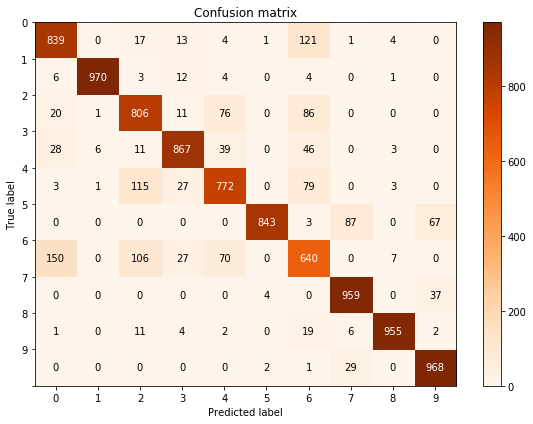

In [15]:
cnf_matrix = compute_confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=list(set(y_test)),
                      title='Confusion matrix')

In [16]:
# Print Classification Report
print(f"{'Label'}{'precision':>10} {'recall':>5} {'f1-score':>5} {'support':>5}")
for label in range(10):
    print(f'{label:5d} {precision(label, cnf_matrix):9.3f} {recall(label, cnf_matrix):6.3f} \
{f1_score(label, cnf_matrix):8.3f}{support(label, cnf_matrix):8.0f}')

Label precision recall f1-score support
    0     0.801  0.839    0.820    1000
    1     0.992  0.970    0.981    1000
    2     0.754  0.806    0.779    1000
    3     0.902  0.867    0.884    1000
    4     0.798  0.772    0.785    1000
    5     0.992  0.843    0.911    1000
    6     0.641  0.640    0.640    1000
    7     0.886  0.959    0.921    1000
    8     0.982  0.955    0.968    1000
    9     0.901  0.968    0.933    1000
